In [2]:
import asyncio
import aiohttp
import aiomoex
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Importing data from MOEX. 
#### In this case we use package  ``` aiomoex ```, which import data from ISS

In [43]:
async def get_data_from_moex(security):
    async with aiohttp.ClientSession() as session:
        data1 = await aiomoex.get_market_candles(session,
                                                 security= security, 
                                                 interval = 24, 
                                                 start = '2021-12-01' )
    return pd.DataFrame(data1)
        
data = await get_data_from_moex('GAZP')
data.index = pd.to_datetime(data['begin'].values)
data

,open,close,high,low,value,volume,begin,end
2021-12-01,338.51,345.21,350.37,337.61,3.210540e+10,93124760,2021-12-01 00:00:00,2021-12-01 23:59:59
2021-12-02,347.30,350.30,352.67,344.80,2.632705e+10,75484820,2021-12-02 00:00:00,2021-12-02 23:59:59
2021-12-03,351.50,345.99,353.13,343.21,1.801471e+10,51710280,2021-12-03 00:00:00,2021-12-03 23:59:59
2021-12-06,347.21,338.94,349.36,333.35,2.403499e+10,71017940,2021-12-06 00:00:00,2021-12-06 23:59:59
2021-12-07,339.25,344.96,346.00,333.43,2.561049e+10,75514200,2021-12-07 00:00:00,2021-12-07 23:59:59
...,...,...,...,...,...,...,...,...
2022-10-26,173.16,171.98,173.42,168.70,5.913060e+09,34577420,2022-10-26 00:00:00,2022-10-26 23:59:59
2022-10-27,172.50,172.47,173.98,171.30,4.032360e+09,23317060,2022-10-27 00:00:00,2022-10-27 23:59:59
2022-10-28,171.89,170.73,172.35,169.41,5.077443e+09,29765070,2022-10-28 00:00:00,2022-10-28 23:59:59
2022-10-31,170.73,170.27,171.50,169.21,2.727443e+09,16029910,2022-10-31 00:00:00,2022-10-31 23:59:59


#### Сalculating returns as a percentage

In [44]:
POINTS = 100 #the number of points on which we build the model
price = data['close'][-(POINTS+1):]
rtrn = price.pct_change().dropna()
rtrn

2022-06-15   -0.004690
2022-06-16    0.002498
2022-06-17   -0.004700
2022-06-20   -0.011157
2022-06-21   -0.033335
                ...   
2022-10-26   -0.002320
2022-10-27    0.002849
2022-10-28   -0.010089
2022-10-31   -0.002694
2022-11-01   -0.001644
Name: close, Length: 100, dtype: float64

## VaR Model.
#### Data usage for the last 100 days, the last one is 2022-11-01 <br /> Quantile level value is 0.05 <br /> ES - Expected Shortfall

<Figure size 1600x500 with 0 Axes>

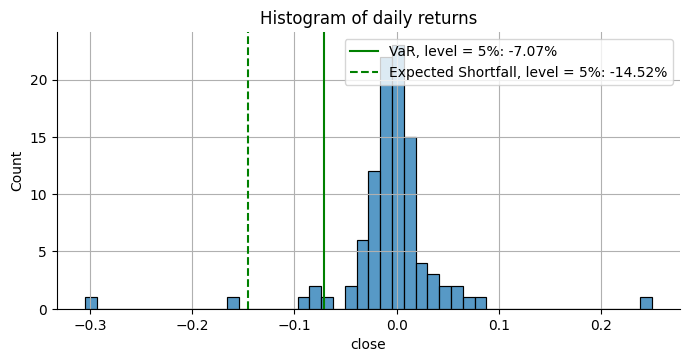

In [74]:
VaR = rtrn.quantile(0.05)
ES = rtrn[rtrn < VaR].mean()

fig = plt.figure(figsize=(16, 5))

sns.displot(rtrn, kind="hist", height = 3.5, aspect = 2)
plt.grid(True)
plt.axvline(x= VaR, linewidth=1.5, color="g")
plt.axvline(ES, linewidth=1.5, color='g', linestyle='dashed')

plt.title("Histogram of daily returns")

plt.legend(['VaR, level = 5%: {:.2f}%'.format(100*VaR), 
            'Expected Shortfall, level = 5%: {:.2f}%'.format(100*ES)])

plt.show()

### Historical Simulation

In [75]:
def calc_var_value_in_history(r, points_num=100, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(points_num, len(r)):
        history = r[i - points_num: i]
        VaR[i] = history.quantile(level)
        
    return pd.Series(data=VaR, index=r.index)

history_return = data['close'].pct_change().dropna()
VaR_historical = calc_var_value_in_history(history_return)

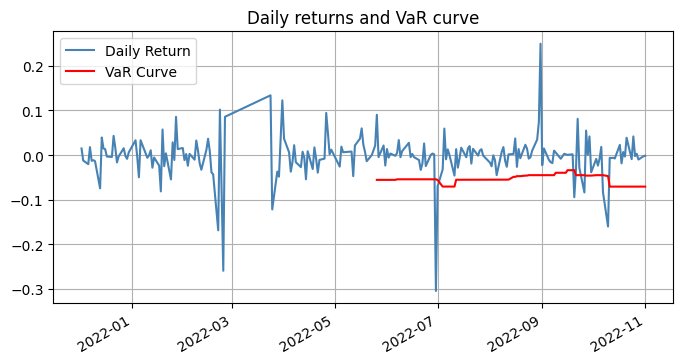

In [76]:
fig = plt.figure(figsize=(8, 4))

data['close'].pct_change().dropna().plot(c = 'steelblue')
VaR_historical.plot(color='r')

plt.grid('True')
plt.title("Daily returns and VaR curve")
plt.legend(['Daily Return', 'VaR Curve'])
plt.show()